# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [53]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [54]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))  #  Створюється Dataset з тензорів "x_train" і "y_train"
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [55]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)

        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="layer1")

    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(in_features=128, out_features=256, name="layer2")

    # Вихідний шар
    self.output_layer = DenseLayer(in_features=256, out_features=num_classes, name="output_layer")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    output = self.output_layer(x, activation=1)

    return output

In [56]:
class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=10)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.layer_3(x, 1)


In [57]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Отримаємо індекс максимального значення для кожного класу
    predicted_classes = tf.argmax(y_pred, axis=1)

    # Отримаємо індекси правильних класів
    y_true = tf.one_hot(y_true, depth=num_classes)
    true_classes = tf.argmax(y_true, axis=1)

    # Порівняємо передбачені та правильні класи
    correct_predictions = tf.equal(predicted_classes, true_classes)

    # Обчислимо середню точність
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

    return accuracy

In [58]:
# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо (оновимо) параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

  return pred, loss

In [59]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

In [60]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Навчання моделі
    train_process = train(neural_net, batch_x, batch_y)
    # Поточне значення втрат
    current_loss = train_process[1]
    # Поточне значення точності
    current_accuracy = accuracy(train_process[0], batch_y)

    if step % display_step == 0:  # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності
        loss_history.append(current_loss.numpy())
        accuracy_history.append(current_accuracy.numpy())


In [61]:
print(loss_history)
print(accuracy_history)

[412.43704, 273.15942, 261.57996, 183.74072, 171.37279, 203.87753, 112.629776, 122.744705, 137.5996, 148.32175, 110.044556, 59.183083, 108.258064, 99.75263, 128.00171, 88.33942, 86.97427, 106.92988, 96.604866, 78.09706, 81.56239, 102.12782, 60.267647, 58.97036, 131.74786, 74.55679, 71.072334, 47.757294, 52.200317, 83.83533]
[0.6328125, 0.75390625, 0.75390625, 0.81640625, 0.81640625, 0.80078125, 0.86328125, 0.8515625, 0.8671875, 0.8359375, 0.890625, 0.921875, 0.8828125, 0.8828125, 0.85546875, 0.8984375, 0.90234375, 0.890625, 0.8984375, 0.91015625, 0.921875, 0.89453125, 0.9296875, 0.93359375, 0.86328125, 0.91796875, 0.921875, 0.9375, 0.94921875, 0.90234375]


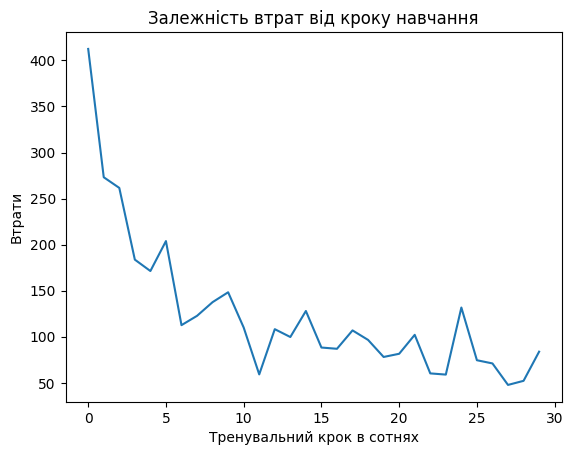

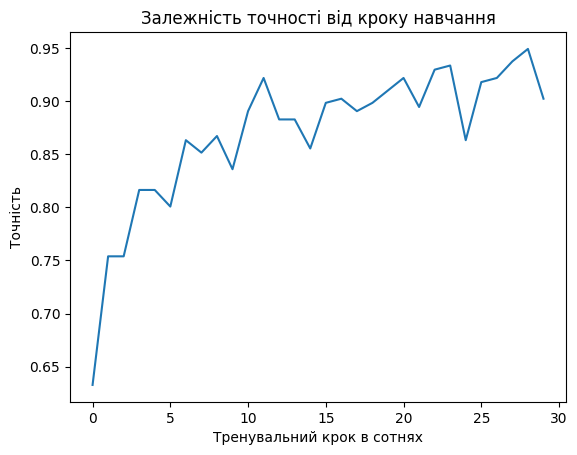

In [62]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history)
plt.xlabel('Тренувальний крок в сотнях')
plt.ylabel('Втрати')
plt.title('Залежність втрат від кроку навчання')
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history)
plt.xlabel('Тренувальний крок в сотнях')
plt.ylabel('Точність')
plt.title('Залежність точності від кроку навчання')
plt.show()

In [63]:
# Обчисліть точність навченої нейромережі
predictions = neural_net(x_test)  # отримання прогнозів на тестовій вибірці
accuracy_total = accuracy(predictions, y_test)  # розрахунок точності
print(accuracy_total.numpy())  # вивід значення точності з отриманого тензора


0.9051


In [81]:
def display_some_examples(examples, labels, predicts=None):

    plt.figure(figsize=(12,12))

    for i in range(5):

        idx = np.random.randint(0, examples.shape[0]-1)
        img = examples[idx].reshape(28, 28)

        label = str(labels[idx])
        if predicts is not None:
          label = f'{label} (прогноз: {np.argmax(predicts[idx])})'

        plt.subplot(5,5,i+1)
        plt.title(label)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')

    plt.show()

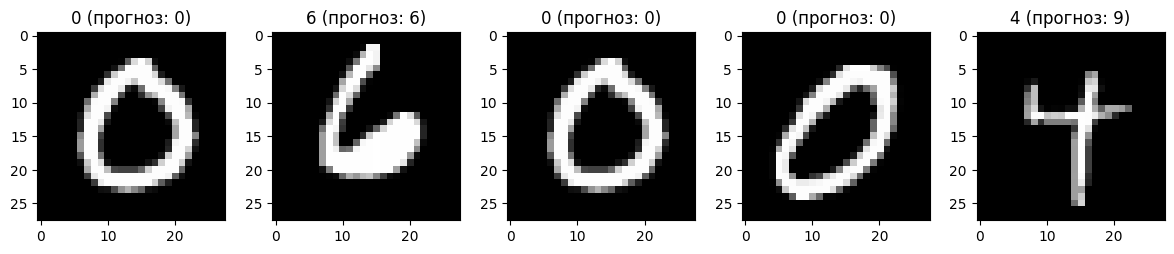

In [82]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється ваша нейронна мережа, і якщо так, то як часто?

from random import sample  # для випадкового вибору певної кількості елементів із заданого об'єкту

# Виберемо з тестової вибірки 10 випадкових індексів зображень
random_indices = sample(range(len(x_test)), 10)

# Визначемо відповідні до обраних індексів зображення та мітки з тестового набору даних
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Зробимо прогноз для обраних випадкових зображень
sample_predictions = neural_net(sample_images)

display_some_examples(sample_images, sample_labels, sample_predictions)